# Simple shape recognition

In [1]:
import lettertask as lt
import patches
import torch
import numpy as np
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import plotnine as gg
from tqdm import tqdm
import lazytools_sflippl as lazytools

In [135]:
agbm = lt.data.AtomicGeometricBinaryModel(width=2, samples=100000)

In [139]:
agbm_flat = agbm.to_array().reshape(-1, 4)
agbm_flat

array([[0., 0., 1., 1.],
       [1., 1., 0., 0.],
       [0., 0., 1., 1.],
       ...,
       [1., 0., 1., 0.],
       [0., 1., 0., 1.],
       [1., 0., 1., 0.]])

## Supervised model

In [140]:
cts = patches.data.HiddenMarkovModel(agbm_flat, agbm.values)

In [32]:
class SupervisedCNN(nn.Module):
    def __init__(self, latent_features, input_features=None,
                 data=None, bias=True):
        super().__init__()
        if data:
            input_features = input_features or data.n_vars
        elif input_features is None or timesteps is None:
            raise ValueError('You must either provide data or both input '
                             'features and timesteps.')
        self.latent_features = latent_features
        self.recognition = nn.Linear(input_features, 2*latent_features)
        self.nonlinearity = nn.ReLU()
        self.shifter = nn.Linear(2*latent_features, latent_features)

    def forward(self, x):
        latent = self.recognition(x['input'])
        latent = self.nonlinearity(latent)
        latent = self.shifter(latent)
        return latent

In [33]:
scnn = SupervisedCNN(1, data=cts)

In [148]:
cdl = torch.utils.data.DataLoader(cts, batch_size=8, drop_last=True)

In [35]:
optimizer = optim.Adam(scnn.parameters())
criterion = nn.MSELoss()
loss_traj = []
running_loss = 0
for epoch in tqdm(range(10)):
    running_loss = 0
    for i, data in enumerate(cdl):
        if i<len(cdl):
            optimizer.zero_grad()
            prediction = scnn(data)
            loss = criterion(prediction, data['latent_values'])
            loss.backward()
            optimizer.step()
            running_loss += loss
            if i % 50 == 49:
                loss_traj.append(running_loss.detach().numpy()/50)
                running_loss = 0

100%|██████████| 10/10 [00:18<00:00,  1.77s/it]


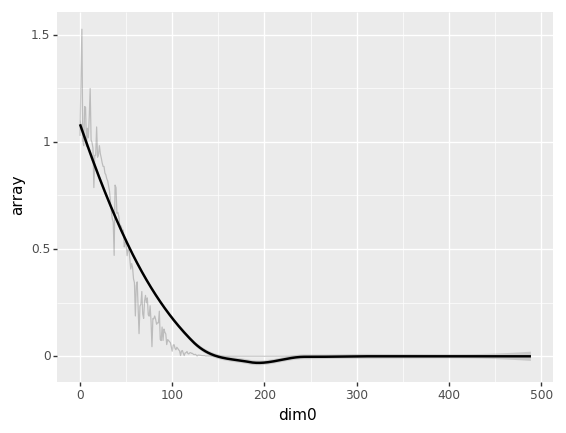

<ggplot: (8738117112980)>

In [36]:
(gg.ggplot(lazytools.array_to_dataframe(np.array(loss_traj)),
           gg.aes(x='dim0', y='array')) +
    gg.geom_line(alpha=0.2) +
    gg.geom_smooth())

In [37]:
list(scnn.parameters())

[Parameter containing:
 tensor([[-0.3011,  1.3222, -0.5326,  1.5537],
         [-0.8771,  0.9711, -1.0244,  1.1124]], requires_grad=True),
 Parameter containing:
 tensor([ 0.8268, -0.1251], requires_grad=True),
 Parameter containing:
 tensor([[ 1.0823, -2.0464]], requires_grad=True),
 Parameter containing:
 tensor([-1.], requires_grad=True)]

In [130]:
def reaction(module):
    shapes = [
        torch.tensor([[1., 1], [0, 0]]),
        torch.tensor([[0., 0], [1, 1]]),
        torch.tensor([[1., 0], [1, 0]]),
        torch.tensor([[0., 1], [0, 1]])
    ]
    reaction = []
    for arr in shapes:
        reaction.append(module.nonlinearity((module.recognition(arr.flatten()))).detach().numpy())
    return np.array(reaction)

In [132]:
reaction(scnn)

array([[1.8478427, 0.       ],
       [1.8478427, 0.       ],
       [0.       , 0.       ],
       [3.7026415, 1.958362 ]], dtype=float32)

In [65]:
list(scnn.parameters())

[Parameter containing:
 tensor([[-0.3011,  1.3222, -0.5326,  1.5537],
         [-0.8771,  0.9711, -1.0244,  1.1124]], requires_grad=True),
 Parameter containing:
 tensor([ 0.8268, -0.1251], requires_grad=True),
 Parameter containing:
 tensor([[ 1.0823, -2.0464]], requires_grad=True),
 Parameter containing:
 tensor([-1.], requires_grad=True)]

## Supervised prediction

In [149]:
class SupervisedPredictiveCNN(nn.Module):
    def __init__(self, latent_features, input_features=None,
                 data=None, bias=True):
        super().__init__()
        if data:
            input_features = input_features or data.n_vars
        elif input_features is None or timesteps is None:
            raise ValueError('You must either provide data or both input '
                             'features and timesteps.')
        self.latent_features = latent_features
        self.recognition = nn.Linear(input_features, 2*latent_features)
        self.nonlinearity = nn.ReLU()
        self.shifter = nn.Linear(2*latent_features, latent_features)
        self.predictor = nn.Linear(latent_features, 5*latent_features)

    def forward(self, x):
        latent = self.recognition(x['input'])
        latent = self.nonlinearity(latent)
        latent = self.shifter(latent)
        latent = self.predictor(latent).reshape(-1, 5, self.latent_features)
        return latent

In [150]:
spcnn = SupervisedPredictiveCNN(1, data=cts)

In [151]:
optimizer = optim.Adam(spcnn.parameters())
criterion = nn.MSELoss()
loss_traj = []
running_loss = 0
for epoch in tqdm(range(10)):
    running_loss = 0
    for i, data in enumerate(cdl):
        if i<len(cdl):
            optimizer.zero_grad()
            prediction = spcnn(data)
            loss = criterion(prediction, data['future_latent_values'])
            loss.backward()
            optimizer.step()
            running_loss += loss
            if i % 50 == 49:
                loss_traj.append(running_loss.detach().numpy()/50)
                running_loss = 0

100%|██████████| 10/10 [02:03<00:00, 12.34s/it]


/home/sflippl/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


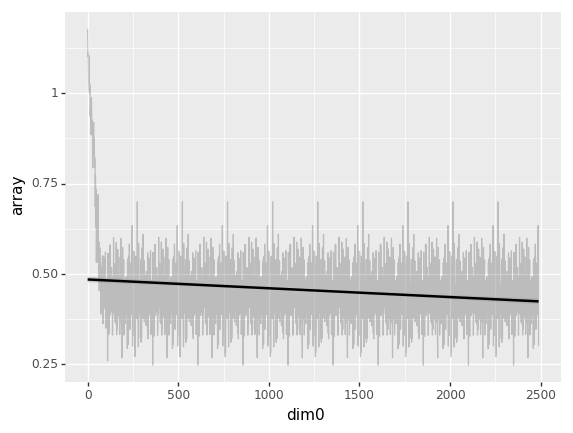

<ggplot: (8738106920319)>

In [152]:
(gg.ggplot(lazytools.array_to_dataframe(np.array(loss_traj)),
           gg.aes(x='dim0', y='array')) +
    gg.geom_line(alpha=0.2) +
    gg.geom_smooth())

In [153]:
reaction(spcnn)

array([[2.1118238, 0.       ],
       [0.       , 2.0657213],
       [0.       , 0.       ],
       [0.       , 0.       ]], dtype=float32)

## Contrastive coding

In [163]:
ccts = patches.data.Contrastive1DTimeSeries(agbm_flat, n_contrasts=10)

In [209]:
class SupervisedCNN(nn.Module):
    def __init__(self, latent_features, input_features=None,
                 data=None, bias=True):
        super().__init__()
        if data:
            input_features = input_features or data.n_vars
        elif input_features is None or timesteps is None:
            raise ValueError('You must either provide data or both input '
                             'features and timesteps.')
        self.latent_features = latent_features
        self.recognition = nn.Linear(input_features, 10*latent_features)
        self.nonlinearity = nn.ReLU()
        self.layer_2 = nn.Linear(10*latent_features, 2*latent_features)
        self.shifter = nn.Linear(2*latent_features, latent_features)

    def forward(self, x):
        latent = self.recognition(x)
        latent = self.nonlinearity(latent)
        latent = self.layer_2(latent)
        latent = self.shifter(latent)
        return latent

In [210]:
class TwoLayeredScaffold(patches.networks.SimpleScaffold):
    def __init__(self):
        super().__init__()
        self.encoder = SupervisedCNN(1, data=ccts)
        self.predictor = nn.Linear(1, 5)

    def encode(self, x):
        return self.encoder(x)

    def predict(self, x):
        return self.predictor(x)

In [211]:
tls = TwoLayeredScaffold()

In [212]:
criterion = patches.losses.ContrastiveLoss(loss=patches.losses.BilinearLoss())

In [213]:
cdl = torch.utils.data.DataLoader(ccts, drop_last=True, batch_size=8)

In [219]:
optimizer = optim.Adam(tls.parameters(), lr=2e-4)
loss_traj = []
running_loss = 0
n_epochs = 2
with tqdm(total=n_epochs*len(cdl)) as pbar:
    for epoch in range(n_epochs):
        running_loss = 0
        for i, data in enumerate(cdl):
            if i<len(cdl):
                optimizer.zero_grad()
                code = tls(data)
                loss = criterion(code)
                loss.backward()
                optimizer.step()
                running_loss += loss
                if i % 50 == 49:
                    loss_traj.append(running_loss.detach().numpy()/50)
                    running_loss = 0
                pbar.update(1)

100%|██████████| 24998/24998 [01:25<00:00, 291.46it/s]


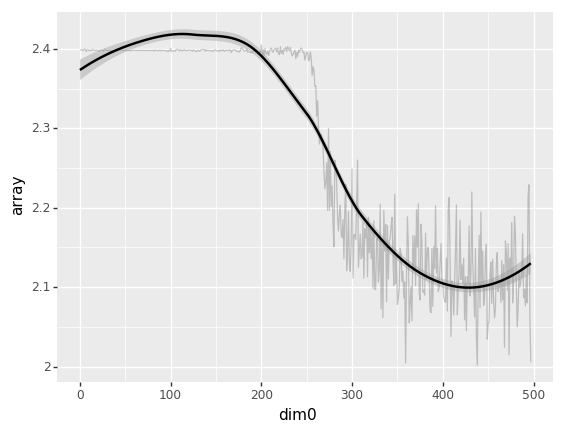

<ggplot: (8738065065150)>

In [220]:
(gg.ggplot(lazytools.array_to_dataframe(np.array(loss_traj)),
           gg.aes(x='dim0', y='array')) +
    gg.geom_line(alpha=0.2) +
    gg.geom_smooth())

In [217]:
reaction(tls.encoder)

array([[0.        , 0.        , 0.        , 0.26246744, 0.11760747,
        0.        , 0.        , 0.9107413 , 0.        , 0.21530226],
       [0.        , 0.        , 0.3131689 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.7251331 , 0.33528548],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.16908337, 0.4808659 , 0.15243438, 0.41830346],
       [0.        , 0.26551086, 0.17354515, 0.        , 0.12910569,
        0.        , 0.        , 0.2813657 , 0.18116304, 0.1322843 ]],
      dtype=float32)

In [221]:
tls.encode(torch.tensor([[1., 1, 0, 0],
                 [0, 0, 1, 1],
                 [1, 0, 1, 0],
                 [0, 1, 0, 1]]))

tensor([[-1.4180],
        [-1.4567],
        [ 0.4783],
        [ 0.4446]], grad_fn=<AddmmBackward>)

For such a complex model, there is a sudden shift after four iterations -- and we have found the right dimension. This suggests a highly nonlinear loss landscape and both the linear and the nonlinear case might be suitable for a more principled mathematical investigation of this landscape as it is an important determinant for the algorithm's performance at more complex tasks. For now, we attempt to distill the model.
For the single nonlinearity, many epochs seemed to not change anything. In light of this new evidence, we will now revisit this case.

In [224]:
class SupervisedCNN(nn.Module):
    def __init__(self, latent_features, input_features=None,
                 data=None, bias=True):
        super().__init__()
        if data:
            input_features = input_features or data.n_vars
        elif input_features is None or timesteps is None:
            raise ValueError('You must either provide data or both input '
                             'features and timesteps.')
        self.latent_features = latent_features
        self.recognition = nn.Linear(input_features, 2*latent_features)
        self.nonlinearity = nn.ReLU()
        self.shifter = nn.Linear(2*latent_features, latent_features)

    def forward(self, x):
        latent = self.recognition(x)
        latent = self.nonlinearity(latent)
        latent = self.shifter(latent)
        return latent

In [240]:
tls = TwoLayeredScaffold()

In [241]:
optimizer = optim.Adam(tls.parameters(), lr=2e-3)
loss_traj = []
running_loss = 0
n_epochs = 60
with tqdm(total=n_epochs*len(cdl)) as pbar:
    for epoch in range(n_epochs):
        running_loss = 0
        for i, data in enumerate(cdl):
            if i<len(cdl):
                optimizer.zero_grad()
                code = tls(data)
                loss = criterion(code)
                loss.backward()
                optimizer.step()
                running_loss += loss
                if i % 50 == 49:
                    loss_traj.append(running_loss.detach().numpy()/50)
                    running_loss = 0
                pbar.update(1)

100%|██████████| 749940/749940 [41:02<00:00, 304.50it/s]


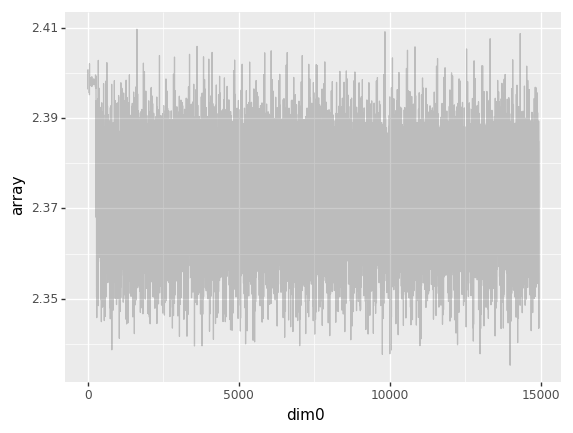

<ggplot: (-9223363298789937639)>

In [242]:
(gg.ggplot(lazytools.array_to_dataframe(np.array(loss_traj)),
           gg.aes(x='dim0', y='array')) +
    gg.geom_line(alpha=0.2))

In [243]:
-np.log(1/11)

2.3978952727983707

In [244]:
np.array(loss_traj).mean()

2.3727616123163715

In [245]:
tls.encode(torch.tensor([[1., 1, 0, 0],
                 [0, 0, 1, 1],
                 [1, 0, 1, 0],
                 [0, 1, 0, 1]]))

tensor([[ 0.0792],
        [-1.1186],
        [ 0.0792],
        [ 0.0792]], grad_fn=<AddmmBackward>)

We have therefore failed to find one dimension. What if we add one more feature dimension?

In [246]:
class SupervisedCNN(nn.Module):
    def __init__(self, latent_features, input_features=None,
                 data=None, bias=True):
        super().__init__()
        if data:
            input_features = input_features or data.n_vars
        elif input_features is None or timesteps is None:
            raise ValueError('You must either provide data or both input '
                             'features and timesteps.')
        self.latent_features = latent_features
        self.recognition = nn.Linear(input_features, 3*latent_features)
        self.nonlinearity = nn.ReLU()
        self.shifter = nn.Linear(3*latent_features, latent_features)

    def forward(self, x):
        latent = self.recognition(x)
        latent = self.nonlinearity(latent)
        latent = self.shifter(latent)
        return latent

In [247]:
tls = TwoLayeredScaffold()

In [248]:
optimizer = optim.Adam(tls.parameters(), lr=2e-3)
loss_traj = []
running_loss = 0
n_epochs = 60
with tqdm(total=n_epochs*len(cdl)) as pbar:
    for epoch in range(n_epochs):
        running_loss = 0
        for i, data in enumerate(cdl):
            if i<len(cdl):
                optimizer.zero_grad()
                code = tls(data)
                loss = criterion(code)
                loss.backward()
                optimizer.step()
                running_loss += loss
                if i % 50 == 49:
                    loss_traj.append(running_loss.detach().numpy()/50)
                    running_loss = 0
                pbar.update(1)

100%|██████████| 749940/749940 [43:27<00:00, 287.57it/s]


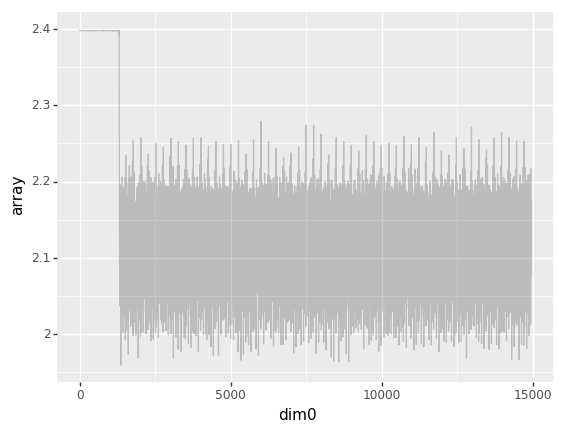

<ggplot: (-9223363298789997182)>

In [249]:
(gg.ggplot(lazytools.array_to_dataframe(np.array(loss_traj)),
           gg.aes(x='dim0', y='array')) +
    gg.geom_line(alpha=0.2))

In [250]:
tls.encode(torch.tensor([[1., 1, 0, 0],
                 [0, 0, 1, 1],
                 [1, 0, 1, 0],
                 [0, 1, 0, 1]]))

tensor([[ 0.8737],
        [ 0.7358],
        [-1.6286],
        [-1.5536]], grad_fn=<AddmmBackward>)